In [158]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils

In [159]:
class vAE(nn.Module):
    def __init__(self):
        super(vAE,self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
#         std = logvar.mul(0.5).exp_()
        std = torch.exp(logvar)
        eps = Variable(torch.FloatTensor(std.size()).normal_())
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In [160]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root = './', train = True, download = True,transform = transform)
testset = torchvision.datasets.MNIST(root = './', train = False, download = True,transform = transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = False)

In [161]:
# init the network
ae = vAE()

In [162]:
#init optimizer
optimizer = optim.SGD(ae.parameters(), lr = 0.001)
# init loss function
criterion = nn.BCELoss()

In [163]:
def loss_function(new_x, x, mu, logvar):
    BCE = criterion(new_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD

In [164]:
epochs = 50
loss_list = []
predictions_list = []
for epoch in range(0,epochs):
    ae.train()
    train_loss = 0
    # to get the latest predictions for sake of report only
    predictions = []
    for batchId, (data,_) in enumerate(train_loader):
        data  = Variable(data)
        data = data.view(data.size(0),-1)
        # gradient is set to 0
        optimizer.zero_grad()
        # passing through the network
        net_out, mu, logvar = ae(data)
        # calculaing loss
        loss = loss_function(net_out, data, mu, logvar)
        # propogating loss at current step
        loss.backward()
        # updating parameters (in steps) after gradient descent
        optimizer.step()
        # calculate total loss
        train_loss += loss
        # predictions
#         predictions.append(net_out)
#         predictions_list.append(net_out)
    loss_list.append(train_loss)
    print('Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))

Epoch: 0 Average loss: 0.0167
Epoch: 1 Average loss: 0.0116
Epoch: 2 Average loss: 0.0110
Epoch: 3 Average loss: 0.0109
Epoch: 4 Average loss: 0.0107
Epoch: 5 Average loss: 0.0106
Epoch: 6 Average loss: 0.0106
Epoch: 7 Average loss: 0.0105
Epoch: 8 Average loss: 0.0104
Epoch: 9 Average loss: 0.0103
Epoch: 10 Average loss: 0.0103
Epoch: 11 Average loss: 0.0102
Epoch: 12 Average loss: 0.0101
Epoch: 13 Average loss: 0.0101
Epoch: 14 Average loss: 0.0100
Epoch: 15 Average loss: 0.0099
Epoch: 16 Average loss: 0.0099
Epoch: 17 Average loss: 0.0098
Epoch: 18 Average loss: 0.0098
Epoch: 19 Average loss: 0.0097
Epoch: 20 Average loss: 0.0096
Epoch: 21 Average loss: 0.0096
Epoch: 22 Average loss: 0.0095
Epoch: 23 Average loss: 0.0095
Epoch: 24 Average loss: 0.0094
Epoch: 25 Average loss: 0.0093
Epoch: 26 Average loss: 0.0093
Epoch: 27 Average loss: 0.0092
Epoch: 28 Average loss: 0.0092
Epoch: 29 Average loss: 0.0091
Epoch: 30 Average loss: 0.0091
Epoch: 31 Average loss: 0.0090
Epoch: 32 Average 

In [165]:
torch.save(ae, "hw5_vae.pth")

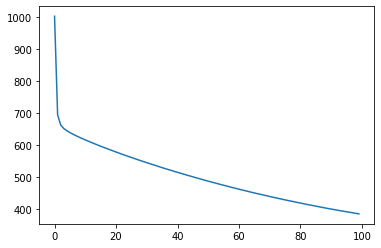

In [166]:
plt.plot(loss_list)
plt.savefig(fname='vae.png',format='png')